In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [3]:
import findspark
findspark.init()

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import lag, col, expr, collect_list, udf, lit, to_date, size

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


import numpy as np
import matplotlib.pyplot as plt

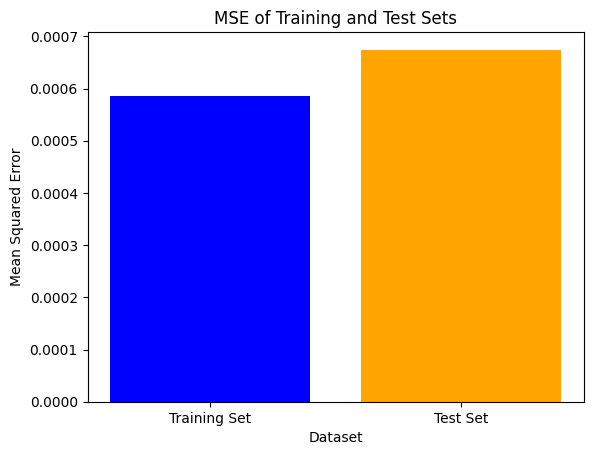

In [2]:
class StockPriceRegression:
    def __init__(self, file_path):
        self.spark = SparkSession.builder.appName("StockPriceRegression").getOrCreate()
        self.df = self.spark.read.csv(file_path, header=True, inferSchema=True)

    def preprocess_data(self):
        self.df = self.df.withColumn("Ngay", to_date(col('Ngay'), 'dd/MM/yyyy'))

        window_spec = Window.orderBy("Ngay")
        self.df = self.df.withColumn("prev_price", lag("HVN").over(window_spec))
        self.df = self.df.withColumn("fluctuation", (col("HVN") - col("prev_price")) / col("prev_price"))
        self.df = self.df.fillna({"fluctuation": 0})

    def split_data(self):
        self.train_df = self.df.filter(col("Ngay") <= '2022-06-30')
        self.test_df = self.df.filter(col("Ngay") > '2022-06-30')

    def create_features(self, df, window=5):
        window_spec = Window.orderBy("Ngay").rowsBetween(-window, -1)
        df = df.withColumn("ranges", collect_list("fluctuation").over(window_spec))
        df = df.withColumn("range_size", size(col("ranges")))
        df = df.filter(col("range_size") == window).drop("range_size")
        return df

    def prepare_data(self):
        self.train_df = self.create_features(self.train_df)
        self.test_df = self.create_features(self.test_df)

        self.train_data = self.train_df.select("ranges", "fluctuation") \
                                      .withColumnRenamed("fluctuation", "today_range")

        self.test_data = self.test_df.select("ranges", "fluctuation") \
                                    .withColumnRenamed("fluctuation", "today_range")


        vector_udf = udf(lambda r: Vectors.dense(r), VectorUDT())
        self.train_data = self.train_data.withColumn("ranges",
                                                     vector_udf(col("ranges")))


        self.test_data = self.test_data.withColumn("ranges",
                                                   vector_udf(col("ranges")))

    def train_model(self):
        lr = LinearRegression(featuresCol="ranges", labelCol="today_range")
        self.lr_model = lr.fit(self.train_data)

    def evaluate_model(self):
        self.train_results = self.lr_model.evaluate(self.train_data)
        self.test_results = self.lr_model.evaluate(self.test_data)
        self.train_mse = self.train_results.meanSquaredError
        self.test_mse = self.test_results.meanSquaredError

    def visualize_results(self):
        mse_values = [self.train_mse, self.test_mse]
        labels = ['Training Set', 'Test Set']

        plt.bar(labels, mse_values, color=['blue', 'orange'])
        plt.xlabel('Dataset')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE of Training and Test Sets')
        plt.show()

    def run(self):
        self.preprocess_data()
        self.split_data()
        self.prepare_data()
        self.train_model()
        self.evaluate_model()

if __name__ == "__main__":
    file_path = "stockHVN2022.csv"
    stock_price_regression = StockPriceRegression(file_path)
    stock_price_regression.run()
    stock_price_regression.visualize_results()

{'Training': {'MLP': 0.9411764705882353, 'Random Forest': 0.8514600084638172, 'Linear SVM': 0.8829171956552405}, 'Test': {'MLP': 0.9172105805565098, 'Random Forest': 0.8454139470972174, 'Linear SVM': 0.8691171418756442}}


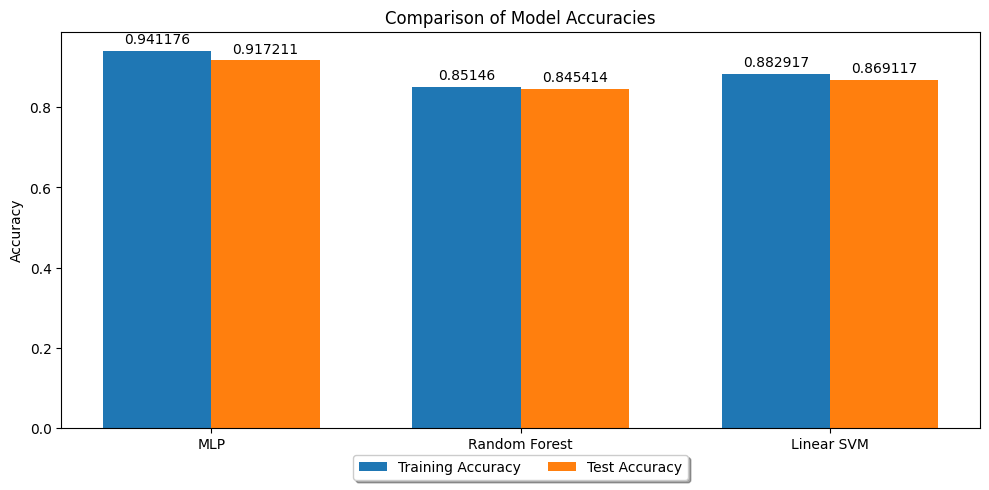

In [3]:
class MultiClassClassifier:
    def __init__(self, data_path):
        self.spark = SparkSession.builder \
                                  .appName("MultiClassClassification") \
                                  .getOrCreate()

        self.evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                                           predictionCol="prediction",
                                                           metricName="accuracy")

        self.models = {}
        self.data_path = data_path
        self.data = self._load_data()
        self.train_data, self.test_data = self._split_data()
        self.accuracies = None


    def _load_data(self):
        data = self.spark.read.csv(self.data_path,
                                   header=False,
                                   inferSchema=True)

        data = data.withColumnRenamed("_c0", "label")
        assembler = VectorAssembler(inputCols=data.columns[1:],
                                    outputCol="features")

        return assembler.transform(data).select("label", "features")

    def _split_data(self):
        return self.data.randomSplit([0.7, 0.3], seed=1234)

    def train_mlp(self):
        layers = [784, 128, 64, 10]
        mlp = MultilayerPerceptronClassifier(layers=layers,
                                             labelCol="label",
                                             featuresCol="features",
                                             seed=1234)

        self.models['MLP'] = mlp.fit(self.train_data)

    def train_rf(self):
        rf = RandomForestClassifier(labelCol="label",
                                    featuresCol="features",
                                    numTrees=20,
                                    seed=1234)

        self.models['Random Forest'] = rf.fit(self.train_data)

    def train_svm(self):
        svm = LinearSVC(labelCol="label",
                        featuresCol="features",
                        maxIter=10,
                        regParam=0.1)

        ovr = OneVsRest(classifier=svm,
                        labelCol="label",
                        featuresCol="features")

        self.models['Linear SVM'] = ovr.fit(self.train_data)

    def evaluate(self):
        accuracies = {'Training': {}, 'Test': {}}
        for name, model in self.models.items():
            train_predictions = model.transform(self.train_data)
            test_predictions = model.transform(self.test_data)

            # Evaluate on training data
            train_accuracy = self.evaluator.evaluate(train_predictions.select("label",
                                                                              "prediction"))

            accuracies['Training'][name] = train_accuracy

            # Evaluate on test data
            test_accuracy = self.evaluator.evaluate(test_predictions.select("label",
                                                                            "prediction"))

            accuracies['Test'][name] = test_accuracy
        print(accuracies)

        return accuracies

    def visualize(self):
        models = list(self.accuracies['Training'].keys())
        train_accuracies = [self.accuracies['Training'][model] for model in models]
        test_accuracies = [self.accuracies['Test'][model] for model in models]

        x = np.arange(len(models))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots(figsize=(10, 5))
        bars1 = ax.bar(x - width/2,
                       train_accuracies,
                       width,
                       label='Training Accuracy')


        bars2 = ax.bar(x + width/2,
                       test_accuracies,
                       width,
                       label='Test Accuracy')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xlabel('Model')
        ax.set_ylabel('Accuracy')
        ax.set_title('Comparison of Model Accuracies')
        ax.set_xticks(x)
        ax.set_xticklabels(models)

        ax.legend(loc='upper center',
                  bbox_to_anchor=(0.5, -0.05),
                  shadow=True, ncol=2)

        ax.bar_label(bars1, padding=3)
        ax.bar_label(bars2, padding=3)

        fig.tight_layout()

        plt.show()

    def run(self):
        self.train_mlp()
        self.train_rf()
        self.train_svm()
        self.accuracies = self.evaluate()

# Example usage
if __name__ == "__main__":
    classifier = MultiClassClassifier("mnist_mini.csv")
    classifier.run()
    classifier.visualize()